# libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import datetime
from itertools import product
from collections import defaultdict
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Rectangle
import pandas as pd
import plotly.express as px
import seaborn as sns


import sys
sys.path.append('../..')
from src.model.theta import KNN
from src.model.simulation import monte_carlo
from src.model.true import check_duration
from src.validation.validation import loss

# Variaveis

In [2]:
def cossine(K, A, phi, f):
    x = list(range(1, 366))
    theta = [
        K + A*np.cos(2*np.pi*f*(i-phi)/365)
        for i in x]
    return theta

In [10]:
def decay(theta, A, years):
    next_years = 10
    values = [
        {
            'date': f"""{
                str(2000 + years + next_years - yi).zfill(4)
                }-{
                datetime.datetime.strptime(str(i+1), '%j').strftime('%m-%d')
                }""",
            'task': (t - A*(max(y, 0)/(years-1))),
            'dataset': ('test' if yi < next_years else 'training')
        }
        for yi, y in enumerate(range(-next_years, years))
        for i, t in enumerate(theta)
        ]
    return pd.DataFrame(values).sort_values('date', ascending=False)

In [3]:
sazonalities = {
    #'constant': np.array([0.5 for i in range(365)]),
    'cossine': np.array(cossine(0.7, 0.2, 240, 1)),
    '2_waves': np.array(cossine(0.8, 0.1, 1, 1))*np.array(cossine(0.8, 0.2, 1, 2)),
    '3_waves': np.array(cossine(.75, 0.25, 1, 2))*np.array(cossine(0.8, 0.2, 240, 1))
    }
experiments = [
    {'amplitude': 0, 'sazonality': 'cossine'},
    {'amplitude': 0.3, 'sazonality': 'cossine'},
    {'amplitude': 0, 'sazonality': '2_waves'},
    {'amplitude': 0, 'sazonality': '3_waves'}
]

In [4]:
hpt = []
for a in [0.6, 0.7, 0.8, 0.9, 1]:
    for w in [0, 3, 7]:    
        hpt.append({'window': w, 'alpha': a, 'fi': 'average_window', 'fy': 'exponencial'})
    hpt.append({'alpha': a, 'fi': 'cossine', 'fy': 'exponencial'})

In [5]:
project_schedule = {
    'task': 90
    }
B=100_000

# Gerando dados

In [6]:
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py

In [7]:
hpt = []
for alpha in [0.85, 0.9, 0.95, 1.]:
    for smoothing in [0, 3, 7]:
        if smoothing  == 0:
            cossines = [True, False]
        else:
            cossines = [False]
        for cossine in cossines:
            hpt.append({'alpha': alpha, 'smoothing': smoothing, 'mc': False, 'cossine': cossine})
hpt

[{'alpha': 0.85, 'smoothing': 0, 'mc': False, 'cossine': True},
 {'alpha': 0.85, 'smoothing': 0, 'mc': False, 'cossine': False},
 {'alpha': 0.85, 'smoothing': 3, 'mc': False, 'cossine': False},
 {'alpha': 0.85, 'smoothing': 7, 'mc': False, 'cossine': False},
 {'alpha': 0.9, 'smoothing': 0, 'mc': False, 'cossine': True},
 {'alpha': 0.9, 'smoothing': 0, 'mc': False, 'cossine': False},
 {'alpha': 0.9, 'smoothing': 3, 'mc': False, 'cossine': False},
 {'alpha': 0.9, 'smoothing': 7, 'mc': False, 'cossine': False},
 {'alpha': 0.95, 'smoothing': 0, 'mc': False, 'cossine': True},
 {'alpha': 0.95, 'smoothing': 0, 'mc': False, 'cossine': False},
 {'alpha': 0.95, 'smoothing': 3, 'mc': False, 'cossine': False},
 {'alpha': 0.95, 'smoothing': 7, 'mc': False, 'cossine': False},
 {'alpha': 1.0, 'smoothing': 0, 'mc': False, 'cossine': True},
 {'alpha': 1.0, 'smoothing': 0, 'mc': False, 'cossine': False},
 {'alpha': 1.0, 'smoothing': 3, 'mc': False, 'cossine': False},
 {'alpha': 1.0, 'smoothing': 7, 'mc'

In [8]:
from src.model.weather_pert import WeatherPert

In [13]:
experiments

[{'amplitude': 0, 'sazonality': 'cossine'},
 {'amplitude': 0.3, 'sazonality': 'cossine'},
 {'amplitude': 0, 'sazonality': '2_waves'},
 {'amplitude': 0, 'sazonality': '3_waves'}]

In [24]:
experimentos = [
    f"Experiment 1", f"Experiment 2"]
fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, shared_yaxes=True,
    subplot_titles= experimentos)
colors = {
    'training': '#1F78B4',
    'test': '#FE7F0E'
}
for i, experiment in enumerate([experiments[1], experiments[3]]):
    row = i + 1
    amplitude = experiment['amplitude']
    sazonality = experiment['sazonality']
    theta = sazonalities[experiment['sazonality']]
    data = decay(theta, A=amplitude, years=30)
    n_training = (data['dataset'] == 'training').sum()
    data['Ano'] = [((len(data) - i) - n_training)/365 for i in range(len(data))]
    data = data[data['Ano'].between(-10, 1)]
    for dataset in ['training', 'test']:
        data_dataset = data.loc[lambda df: df['dataset'] == dataset]

        fig_ = go.Scatter(
            x=data_dataset['Ano'], y=data_dataset['task'],
            mode='lines+markers',
            name='Training' if dataset == 'training' else 'Test',
            line=dict(color=colors[dataset], width=2),
            marker=dict(color=colors[dataset], size=1),
            )
        if i > 0:
            fig_.update(showlegend=False)
        fig.add_trace(fig_, row=row, col=1)

fig.update_xaxes(tickvals=[-15, -10, -5, 0],ticktext=[-15, -10, -5, 0], row=2, col=1)
fig.update_yaxes(title_text='Probability', range=[0,1], row=1, col=1)
fig.update_yaxes(title_text='Probability', range=[0,1], row=2, col=1)
#fig.update_yaxes(title_text='Probability', range=[0,1], row=3, col=1)
#fig.update_yaxes(title_text='Probability', range=[0,1], row=4, col=1)

fig.update_xaxes(title_text='Year', row=2, col=1)
fig.update_layout(
    template = "simple_white",
    width=600, height=450,
    )
fig.write_image("simulado_probabilidades.pdf")

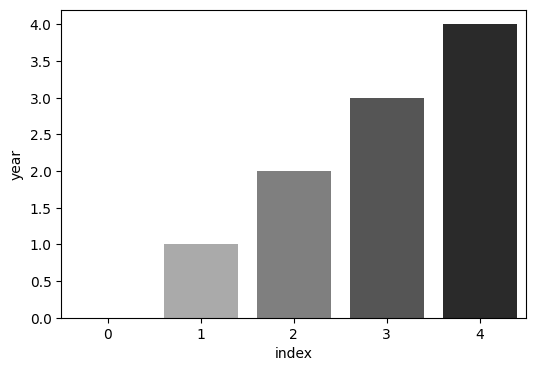

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Rectangle
import pandas as pd
import seaborn as sns

df=pd.DataFrame(data=[i for i in range(5)],columns=['year'])
table=df['year'].reset_index()
fig, ax1 = plt.subplots(figsize=(6,4))
sns.barplot(x='index', y='year', data=table, ax=ax1, palette='gist_gray_r')

bars = [r for r in ax1.get_children() if type(r)==Rectangle]
colors = [c.get_facecolor() for c in bars[:-1]]
colors = [f"rgb({c[0]},{c[1]},{c[2]})" for c in colors]

In [23]:
all_result = {}
result = pd.DataFrame()
comb = len(experiments)
selected_params = pd.DataFrame()
plot_data_values = pd.DataFrame()
exp_plot_crc_values = pd.DataFrame()
for exp_i, experiment in enumerate(experiments):
    amplitude = experiment['amplitude']
    sazonality = experiment['sazonality']
    theta = sazonalities[experiment['sazonality']]
    #data = decay(theta, A=amplitude, years=30)
    
    hpt_result = []
    for date in [
            '2031-01-01', '2031-02-01', '2031-03-01', '2031-04-01',
            '2031-05-01', '2031-06-01', '2031-07-01', '2031-08-01',
            '2031-09-01', '2031-10-01', '2031-11-01', '2031-12-01',
            ]:
        data = decay(theta, A=amplitude, years=30)
        data['dataset'] = data['date'].apply(lambda v: 'test' if  v >= date else 'training')
        data['task'] = data.apply(lambda row: (
            (random.random() <= row['task'])*1 
            if row['dataset']=='training' 
            else row['task']
            ), axis=1)
        
        if date == '2031-01-01':
            plot_data_values = pd.concat([plot_data_values, data.assign(Experiment = f"Experiment {exp_i+1}")])
        training, test = [
            data.loc[lambda df: df.dataset == ds, ['date', 'task']]
            for ds in ['training', 'test']]
        plot_crc_values = pd.DataFrame()
        observed = check_duration(data=test, date_start=date, project_schedule=project_schedule)
        for j, hp in enumerate(hpt):
            start = time.time()
            model = WeatherPert(**hp, column_date='date')
            model.fit(data=training[['date', 'task']])
            crc_knn = model.theta
            param_name = f"alpha={hp['alpha']} | smoothing={hp['smoothing']} | cossine={hp['cossine']}"
            plot_crc_values = pd.concat([plot_crc_values,(
                pd.DataFrame({'theta': crc_knn['task'], 'i': list(range(365))})
                .assign(Parameter = param_name)
                )])
            durations = model.predict(date_start=date, project_schedule=project_schedule)
            
            _loss = loss(observed=observed, estimate=durations, loss_type = 'right-tail')
            hpt_result.append({
                'date': date,
                'sazonality': sazonality,
                'amplitude': amplitude,
                #'mse': fitted.get('mse'),
                #'K': fitted.get('K'),
                #'A': fitted.get('A'),
                #'phi': fitted.get('phi'),
                'alpha': hp['alpha'],
                'smoothing': hp['smoothing'],
                'cossine': hp['cossine'],
                'right-tail': _loss,
                })
            print(f"""{
                str(exp_i).zfill(len(str(comb)))}/{comb
                } |  date={date} | {
                str(j).zfill(len(str(len(hpt))))}/{len(hpt)
                } | {
                round(time.time()-start, 3)
                } s    """, end='\r')
        plot_crc_values = (
            plot_crc_values
            .rename(columns={'i': 'day of year'})
            .assign(
                alpha = lambda df: df['Parameter'].apply(lambda v: v.split(" | ")[0]),
                smoothing = lambda df: df['Parameter'].apply(lambda v: v.split(" | ")[1]),
                cossine = lambda df: df['Parameter'].apply(lambda v: v.split(" | ")[2])
                )
            .sort_values(['alpha', 'smoothing', 'cossine', 'day of year'])
        )
        exp_plot_crc_values = pd.concat([exp_plot_crc_values, plot_crc_values])

        
        #graphs = [
        #    ('smoothing=0', 'cossine=False'),
        #    ('smoothing=0', 'cossine=True'),
        #    ('smoothing=3', 'cossine=False'),
        #    ('smoothing=7', 'cossine=False'),
        #]
        #numerate = ['(a)', '(b)', '(c)', '(d)']
        #if date == '2031-01-01':
        #    fig = make_subplots(
        #        rows=2, cols=2, shared_xaxes=True, shared_yaxes=True,
        #        subplot_titles= [(
        #            f"{numerate[i]} {graph[0]} | {graph[1]}"
        #            ) for i, graph in enumerate(graphs)],
        #        horizontal_spacing = 0.1,
        #        vertical_spacing  = 0.1
        #        )
#
        #    axis = {0: (1, 1), 1: (1, 2), 2: (2, 1), 3: (2, 2)}
        #    for j, graph in enumerate(graphs):
        #        smoothing = graph[0]
        #        cossine = graph[1]
        #        x_i, y_i = axis[j]
        #        df_plot_i = (
        #            df_plot
        #            .loc[lambda df: (df.smoothing==smoothing)&(df.cossine==cossine)]
        #            .sort_values('day of year')
        #            )
        #        
        #        for i, a in enumerate([0.85, 0.9, 0.95, 1.0]):
        #            x = df_plot_i.loc[lambda df: df.alpha == f'alpha={a}', 'day of year'].tolist()
        #            y = df_plot_i.loc[lambda df: df.alpha == f'alpha={a}', 'theta'].tolist()
        #            fig_ = go.Scatter(
        #                x=x, y=y,
        #                mode='lines',
        #                name=a,
        #                line=dict(color=colors[i], width=2)
        #                )
        #            if j > 0:
        #                fig_.update(showlegend=False)
        #            fig.add_trace(fig_, row=x_i, col=y_i)
        #    fig.update_layout(
        #        template = "simple_white",
        #        width=800, height=500,
        #        margin=dict(t=50)
        #        )
        #    fig.update_layout(legend_title_text='alpha')
        #    fig.update_xaxes(title_text='$i$', row=2, col=1)
        #    fig.update_xaxes(title_text='$i$', row=2, col=2)
        #    fig.update_yaxes(title_text='$\widehat \\theta_{t,i}$', row=1, col=1)
        #    fig.update_yaxes(title_text='$\widehat \\theta_{t,i}$', row=2, col=1)
        #    fig.update_layout(legend=dict(orientation='v', yanchor='bottom', y=0.8))#))
        #    #fig.write_image(f'simulado_theta_{exp_i+1}.pdf')
    hpt_result = pd.DataFrame(hpt_result).assign(Experimento = f"Experimento {exp_i+1}")
    result = pd.concat([result, hpt_result])

In [25]:
experiments

[{'amplitude': 0, 'sazonality': 'cossine'},
 {'amplitude': 0.3, 'sazonality': 'cossine'},
 {'amplitude': 0, 'sazonality': '2_waves'},
 {'amplitude': 0, 'sazonality': '3_waves'}]

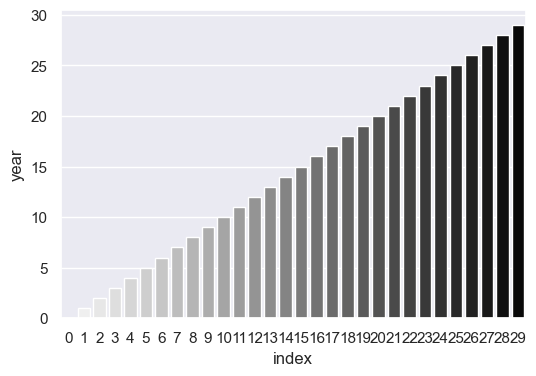

In [27]:
%matplotlib inline
sns.set()

df=pd.DataFrame(data=[i for i in range(30)],columns=['year'])
table=df['year'].reset_index()
fig, ax1 = plt.subplots(figsize=(6,4))
sns.barplot(x='index', y='year', data=table, ax=ax1, palette='gist_gray_r')

bars = [r for r in ax1.get_children() if type(r)==Rectangle]
gray_colors = [c.get_facecolor() for c in bars[:-1]]
gray_colors = [f"rgb({c[0]},{c[1]},{c[2]})" for c in gray_colors]
gray_colors.sort()

In [32]:
colors = [
    {'cossine': 'cossine=True', 'smoothing': 'smoothing=0', 'alpha': 'alpha=0.9', 'color': '#E06666', 'color_alpha': '#e06666d2'},
    {'cossine': 'cossine=True', 'smoothing': 'smoothing=0', 'alpha': 'alpha=0.95', 'color': '#CC0100', 'color_alpha': '#cc0100cd'},
    {'cossine': 'cossine=True', 'smoothing': 'smoothing=0', 'alpha': 'alpha=1.0', 'color': '#660000', 'color_alpha': '#660000d3'},
    {'cossine': 'cossine=False', 'smoothing': 'smoothing=0', 'alpha': 'alpha=0.9', 'color': '#A4C2F4', 'color_alpha': '#a4c2f4d3'},
    {'cossine': 'cossine=False', 'smoothing': 'smoothing=0', 'alpha': 'alpha=0.95', 'color': '#3C78D8', 'color_alpha': '#3c78d8d2'},
    {'cossine': 'cossine=False', 'smoothing': 'smoothing=0', 'alpha': 'alpha=1.0', 'color': '#1C4586', 'color_alpha': '#1c4586d0'},
    {'cossine': 'cossine=False', 'smoothing': 'smoothing=7', 'alpha': 'alpha=0.9', 'color': '#93C47D', 'color_alpha': '#93c47dd2'},
    {'cossine': 'cossine=False', 'smoothing': 'smoothing=7', 'alpha': 'alpha=0.95', 'color': '#38761D', 'color_alpha': '#38761dcf'},
    {'cossine': 'cossine=False', 'smoothing': 'smoothing=7', 'alpha': 'alpha=1.0', 'color': '#284E13', 'color_alpha': '#284e13d0'}
    ]

In [35]:
alphas = {
    'alpha=0.85': dict(symbol='circle', color='#1F77B4'),
    'alpha=0.9': dict(symbol='square', color='#D62728'),
    'alpha=0.95': dict(symbol='cross', color='#2CA02C'),
    'alpha=1.0': dict(symbol='x', color='#FF7F0E')
}

In [36]:
sort_xaxis = [
    "smoothing=0 | cossine=True",
    "smoothing=0 | cossine=False",
    "smoothing=3 | cossine=False",
    "smoothing=7 | cossine=False"]

In [38]:
all_result = {}
result = pd.DataFrame()
comb = len(experiments)
selected_params = pd.DataFrame()
plot_data_values = pd.DataFrame()
exp_plot_crc_values = pd.DataFrame()
for exp_i, experiment in enumerate([experiments[1], experiments[3]]):
    amplitude = experiment['amplitude']
    sazonality = experiment['sazonality']
    theta = sazonalities[experiment['sazonality']]
    #data = decay(theta, A=amplitude, years=30)
    
    hpt_result = []
    for date in [
            '2031-01-01', '2031-02-01', '2031-03-01', '2031-04-01',
            '2031-05-01', '2031-06-01', '2031-07-01', '2031-08-01',
            '2031-09-01', '2031-10-01', '2031-11-01', '2031-12-01',
            ]:
        data = decay(theta, A=amplitude, years=30)
        data['dataset'] = data['date'].apply(lambda v: 'test' if  v >= date else 'training')
        data['task'] = data.apply(lambda row: (
            (random.random() <= row['task'])*1 
            if row['dataset']=='training' 
            else row['task']
            ), axis=1)
        
        if date == '2031-01-01':
            plot_data_values = pd.concat([plot_data_values, data.assign(Experiment = f"Experiment {exp_i+1}")])
        training, test = [
            data.loc[lambda df: df.dataset == ds, ['date', 'task']]
            for ds in ['training', 'test']]
        plot_crc_values = pd.DataFrame()
        observed = check_duration(data=test, date_start=date, project_schedule=project_schedule)
        for j, hp in enumerate(hpt):
            start = time.time()
            model = WeatherPert(**hp, column_date='date')
            model.fit(data=training[['date', 'task']])
            crc_knn = model.theta
            param_name = f"alpha={hp['alpha']} | smoothing={hp['smoothing']} | cossine={hp['cossine']}"
            plot_crc_values = pd.concat([plot_crc_values,(
                pd.DataFrame({'theta': crc_knn['task'], 'i': list(range(365))})
                .assign(Parameter = param_name)
                )])
            durations = model.predict(date_start=date, project_schedule=project_schedule)
            
            _loss = loss(observed=observed, estimate=durations, loss_type = 'right-tail')
            hpt_result.append({
                'date': date,
                'sazonality': sazonality,
                'amplitude': amplitude,
                #'mse': fitted.get('mse'),
                #'K': fitted.get('K'),
                #'A': fitted.get('A'),
                #'phi': fitted.get('phi'),
                'alpha': hp['alpha'],
                'smoothing': hp['smoothing'],
                'cossine': hp['cossine'],
                'right-tail': _loss,
                })
            print(f"""{
                str(exp_i).zfill(len(str(comb)))}/{comb
                } |  date={date} | {
                str(j).zfill(len(str(len(hpt))))}/{len(hpt)
                } | {
                round(time.time()-start, 3)
                } s    """, end='\r')
        plot_crc_values = (
            plot_crc_values
            .rename(columns={'i': 'day of year'})
            .assign(
                alpha = lambda df: df['Parameter'].apply(lambda v: v.split(" | ")[0]),
                smoothing = lambda df: df['Parameter'].apply(lambda v: v.split(" | ")[1]),
                cossine = lambda df: df['Parameter'].apply(lambda v: v.split(" | ")[2])
                )
            .sort_values(['alpha', 'smoothing', 'cossine', 'day of year'])
        )
        exp_plot_crc_values = pd.concat([exp_plot_crc_values, plot_crc_values])

        
        fig = make_subplots(
            rows=3, cols=1, shared_xaxes=False,
            shared_yaxes=False, row_heights=[0.45, 0.45, 0.1],
            subplot_titles= [
                "<b>(A) Simulated data</b>",
                "(B1) Estimated parameters",
                "(B2) Hyperparameter performance"
            ],
            horizontal_spacing = 0.1,
            vertical_spacing  = 0.12
            )
        fig.add_annotation(dict(
            text="<b>(B) Hyperparameters</b>", x=0.5, y=0.57, font=dict(size=18),
            xref="paper", yref="paper", showarrow=False))

        # Figura A
        _data = (
            data
            .assign(
                year = lambda df: df.date.apply(lambda v: ((int(v[:4]))-2000)),
                month = lambda df: df.date.apply(lambda v: int(v[5:7]))
                )
            .assign(year = lambda df: np.where(df.year <= 30, df.year-31, df.year-30))
            .loc[lambda df: df.year <= 0]
            .groupby(['year', 'month', 'dataset'])
            .agg(task=('task', 'mean'))
            .reset_index()
            .sort_values(['year', 'month'], ascending=False)
            .rename(columns={
                'task': 'Dias trabalhados (%)',
                'year': 'Ano',
                'month': 'Mês',
                'Experiment': 'Experimento'
            })
        )
        for i, ano in enumerate(_data['Ano'].unique()):
            fig_ = go.Scatter(
                x=_data.loc[_data['Ano'] == ano, 'Mês'], y=_data.loc[_data['Ano'] == ano, 'Dias trabalhados (%)'], 
                mode='lines', name=str(ano),
                line=dict(color=gray_colors[i], width=2)
                )
            fig_.update(showlegend=False)
            fig.add_trace(fig_, row=1, col=1)
        fig.update_yaxes(title ='Days worked (%)', range=[0, 1], row=1, col=1)
        fig.update_xaxes(title ='Month', range=[1, 12], row=1, col=1)
        # Figura (B), (C)
        _result = (
            pd.DataFrame(hpt_result)
            .groupby(['alpha', 'smoothing', 'cossine'])
            .agg(
                right_tail=('right-tail', 'mean'),
                right_tail_std=('right-tail', np.std),
                count=('right-tail', 'count'),
                )
            .reset_index()
            .sort_values(['right_tail'])
            .assign(
                right_tail_error = lambda df: df['right_tail_std']/np.sqrt(df['count']),
                alpha=lambda df: df['alpha'].apply(lambda v: f"alpha={v}"),
                smoothing=lambda df: df['smoothing'].apply(lambda v: f"smoothing={v}"),
                cossine=lambda df: df['cossine'].apply(lambda v: f"cossine={v}"),
                )
        )

        for color in colors:
        #for alpha in alphas:
        #    # Figura (B)
        #    for smoothing, cossine in [
        #            ('smoothing=0', 'cossine=True'), ('smoothing=0', 'cossine=False'),
        #            ('smoothing=7', 'cossine=False')]:
            name = f"{color['cossine']} | {color['smoothing']} | {color['alpha']}"
            plot_crc_values_i = plot_crc_values.loc[lambda df: (
                (df['alpha'] == color['alpha'])&(df['smoothing'] == color['smoothing'])&(df['cossine'] == color['cossine'])
                )]
            fig_ = go.Scatter(
                x=plot_crc_values_i['day of year'], y=plot_crc_values_i['theta'],
                mode='lines+markers',
                name=name,
                line=dict(color=color['color'], width=1),
                marker=dict(color=color['color'], size=4))
            fig_.update(showlegend=False)
            fig.add_trace(fig_, row=2, col=1)
            fig.update_yaxes(title ='Probability', range=[0, 1], row=2, col=1)
            fig.update_xaxes(title='Day of the year', range=[0, 365], row=2, col=1)
                # Figura (C)
            _result_i = (
                _result
                .loc[lambda df: (
                    (df['alpha'] == color['alpha'])&(df['smoothing'] == color['smoothing'])&(df['cossine'] == color['cossine'])
                    )]
                .assign(
                    theta_name=lambda df: df.apply(lambda row: f"{row['smoothing']} | {row['cossine']}", axis=1).astype(str),
                    sort_xaxis = lambda df: df['theta_name'].apply(lambda x: sort_xaxis.index(x)),
                    ticktext=lambda df: df.apply(lambda row: f"{row['smoothing']}        <br>  {row['cossine']}", axis=1).astype(str),
                    )
                .sort_values(['sort_xaxis', 'alpha'])
                )
            fig_ = go.Scatter(
                x=_result_i['right_tail'], y = [name for i in range(len(_result_i))],
                mode='markers', name=alpha,
                line=dict(color=color['color'], width=2),
                marker=dict(color=color['color'], size=7),
                error_x=dict(
                    type='data', # tipo de barra de erro 
                    array=_result_i['right_tail_error'], # valor do erro em x para cada ponto (direita)
                    arrayminus=_result_i['right_tail_error'], # valor do erro em x para cada ponto (esquerda)
                    visible=True, color=color['color']),
                )

            fig_.update(showlegend=False)
            fig.add_trace(fig_, row=3, col=1)
        #fig.update_layout(legend_title_text='alpha')
        fig.update_yaxes(showticklabels=False, row=3, col=1)
        fig.update_xaxes(title ='Risk', row=3, col=1)

        fig.update_layout(
            yaxis_range=[0,1],
            width=900, height=1100,
            margin=dict(l=0, t=50),
            template = "simple_white",
            xaxis=dict(titlefont=dict(size=16)), yaxis=dict(titlefont=dict(size=16)),
            xaxis2=dict(titlefont=dict(size=16)), yaxis2=dict(titlefont=dict(size=16)),
            xaxis3=dict(titlefont=dict(size=16)), yaxis3=dict(titlefont=dict(size=16)),
            font=dict(color='#434343'),
            title=dict(text=f"Experiment {exp_i+1}", font=dict(size=24, color="black")),
            legend=dict(
                x=0.6,  # Posição horizontal (0.0 à 1.0)
                y=.5,  # Posição vertical (0.0 à 1.0)
                xanchor='center',  # Âncora horizontal
                yanchor='top',  # Âncora vertical
                font=dict(size=12, color="gray"),
                orientation ='h'
            )
        )
        fig.write_image(f'simulado_todos_experimento_{exp_i+1}.pdf')
    hpt_result = pd.DataFrame(hpt_result).assign(Experimento = f"Experimento {exp_i+1}")
    result = pd.concat([result, hpt_result])

In [34]:
sort_xaxis

NameError: name 'sort_xaxis' is not defined

In [90]:
plot_crc_values['alpha'].unique()

array(['alpha=0.85', 'alpha=0.9', 'alpha=0.95', 'alpha=1.0'], dtype=object)

In [134]:
fig = make_subplots(
    rows=6, cols=1, shared_xaxes=False, shared_yaxes=False, row_heights=[0.15, 0.15, 0.15, 0.15, 0.15, 0.2],
    #specs=[
    #        [{"colspan": 2}, None],  # Linha 1: um gráfico que ocupa as duas colunas
    #        [{}, {}],  # Linha 2: dois gráficos
    #        [{}, {}],  # Linha 3: dois gráficos
    #        [{"colspan": 2}, None]   # Linha 4: um gráfico que ocupa as duas colunas
    #    ],
    subplot_titles= [
        "(A) Média mensal de dias trabalháveis",
        "(B-1) smoothing=0 | cossine=False",
        "(B-2) smoothing=0 | cossine=True",
        "(B-3) smoothing=3 | cossine=False",
        "(B-4) smoothing=7 | cossine=False",
        "(C) Desempenho"
    ],
    horizontal_spacing = 0.1,
    vertical_spacing  = 0.1
    )
fig.add_annotation(dict(
    text="(B) Parâmetros estimados", x=0.5, y=0.87, font=dict(size=17),
    xref="paper", yref="paper", showarrow=False))
# Figura A
_data = (
    data
    .assign(
        year = lambda df: df.date.apply(lambda v: ((int(v[:4]))-2000)),
        month = lambda df: df.date.apply(lambda v: int(v[5:7]))
        )
    .assign(year = lambda df: np.where(df.year <= 30, df.year-31, df.year-30))
    .loc[lambda df: df.year <= 0]
    .groupby(['year', 'month', 'dataset'])
    .agg(task=('task', 'mean'))
    .reset_index()
    .sort_values(['year', 'month'], ascending=False)
    .rename(columns={
        'task': 'Dias trabalhados (%)',
        'year': 'Ano',
        'month': 'Mês',
        'Experiment': 'Experimento'
    })
)
for i, ano in enumerate(_data['Ano'].unique()):
    fig_ = go.Scatter(
        x=_data.loc[_data['Ano'] == ano, 'Mês'], y=_data.loc[_data['Ano'] == ano, 'Dias trabalhados (%)'], 
        mode='lines',
        line=dict(color=gray_colors[i], width=2)
        )
    fig_.update(showlegend=False)
    fig.add_trace(fig_, row=1, col=1)
    fig.update_yaxes(range=[0, 1], row=row, col=1)
    fig.update_xaxes(range=[1, 12], row=row, col=1)
# Figura (B), (C)
_result = (
    hpt_result
    .groupby(['Experimento', 'alpha', 'smoothing', 'cossine'])
    .agg(
        right_tail=('right-tail', 'mean'),
        right_tail_std=('right-tail', np.std),
        count=('right-tail', 'count'),
        )
    .reset_index()
    .sort_values(['Experimento','right_tail'])
    .assign(
        right_tail_error = lambda df: df['right_tail_std']/np.sqrt(df['count']),
        alpha=lambda df: df['alpha'].apply(lambda v: f"alpha={v}"),
        smoothing=lambda df: df['smoothing'].apply(lambda v: f"smoothing={v}"),
        cossine=lambda df: df['cossine'].apply(lambda v: f"cossine={v}"),
        )
)

for alpha in alphas:
    # Figura (B)
    for smoothing, cossine, row in [
            ('smoothing=0', 'cossine=True', 2), ('smoothing=0', 'cossine=False', 3),
            ('smoothing=3', 'cossine=False', 4), ('smoothing=7', 'cossine=False', 5)]:
        plot_crc_values_i = plot_crc_values.loc[lambda df: (
            (df['alpha'] == alpha)&(df['smoothing'] == smoothing)&(df['cossine'] == cossine)
            )]
        fig_ = go.Scatter(
            x=plot_crc_values_i['day of year'], y=plot_crc_values_i['theta'],
            mode='lines+markers',
            name=a,
            line=dict(color=alphas[alpha]['color'], width=1),
            marker=dict(**alphas[alpha], size=4))
        fig_.update(showlegend=False)
        fig.add_trace(fig_, row=row, col=1)
        fig.update_yaxes(title ='$\widehat \\theta_{t,i}$', range=[0, 1], row=row, col=1)
        fig.update_xaxes(range=[0, 365], row=row, col=1)
        # Figura (C)
    _result_i = (
        _result
        .loc[lambda df: (
            (df['alpha'] == alpha)#&(df['cossine'] == cossine)
            )]
        .assign(
            theta_name=lambda df: df.apply(lambda row: f"{row['smoothing']} | {row['cossine']}", axis=1).astype(str),
            sort_xaxis = lambda df: df['theta_name'].apply(lambda x: sort_xaxis.index(x)),
            ticktext=lambda df: df.apply(lambda row: f"{row['smoothing']}        <br>  {row['cossine']}", axis=1).astype(str),
            )
        .sort_values(['sort_xaxis', 'alpha'])
        )
    fig_ = go.Scatter(
        x=_result_i['ticktext'], y=_result_i['right_tail'],
        mode='markers+lines', name=alpha,
        line=dict(color=alphas[alpha]['color'], width=2),
        marker=dict(**alphas[alpha], size=10)
        )
    fig_.update(showlegend=False)
    fig.add_trace(fig_, row=6, col=1)
    #fig.update_layout(legend_title_text='alpha')
    fig.update_yaxes(title ='Risco', row=6, col=1)
    fig.update_xaxes(title ='Parâmetros' ,ticktext=ticktext, row=6, col=1)


fig.update_layout(
    yaxis_range=[0,1],
    width=800, height=1600,
    margin=dict(l=0, t=50),
    template = "simple_white",
    # legend=dict(
    #     orientation="h",
    #     yanchor="bottom",
    #     y=1.02,
    #     xanchor="right",
    #     x=1)
    )
fig

In [254]:
fig = make_subplots(
    rows=3, cols=1, shared_xaxes=False,
    shared_yaxes=False, row_heights=[0.45, 0.45, 0.1],
    subplot_titles= [
        "<b>(A) Média mensal de dias trabalháveis</b>",
        "(B1) Parâmetros estimados",
        "(B2) Desepenho de hiperparâmetro"
    ],
    horizontal_spacing = 0.1,
    vertical_spacing  = 0.12
    )
fig.add_annotation(dict(
    text="<b>(B) Hiperparâmetros</b>", x=0.5, y=0.57, font=dict(size=18),
    xref="paper", yref="paper", showarrow=False))

# Figura A
_data = (
    data
    .assign(
        year = lambda df: df.date.apply(lambda v: ((int(v[:4]))-2000)),
        month = lambda df: df.date.apply(lambda v: int(v[5:7]))
        )
    .assign(year = lambda df: np.where(df.year <= 30, df.year-31, df.year-30))
    .loc[lambda df: df.year <= 0]
    .groupby(['year', 'month', 'dataset'])
    .agg(task=('task', 'mean'))
    .reset_index()
    .sort_values(['year', 'month'], ascending=False)
    .rename(columns={
        'task': 'Dias trabalhados (%)',
        'year': 'Ano',
        'month': 'Mês',
        'Experiment': 'Experimento'
    })
)
for i, ano in enumerate(_data['Ano'].unique()):
    fig_ = go.Scatter(
        x=_data.loc[_data['Ano'] == ano, 'Mês'], y=_data.loc[_data['Ano'] == ano, 'Dias trabalhados (%)'], 
        mode='lines', name=str(ano),
        line=dict(color=gray_colors[i], width=2)
        )
    fig_.update(showlegend=False)
    fig.add_trace(fig_, row=1, col=1)
fig.update_yaxes(title ='Dias trabalhados (%)', range=[0, 1], row=1, col=1)
fig.update_xaxes(title ='Mês', range=[1, 12], row=1, col=1)
# Figura (B), (C)
_result = (
    hpt_result
    .groupby(['Experimento', 'alpha', 'smoothing', 'cossine'])
    .agg(
        right_tail=('right-tail', 'mean'),
        right_tail_std=('right-tail', np.std),
        count=('right-tail', 'count'),
        )
    .reset_index()
    .sort_values(['Experimento','right_tail'])
    .assign(
        right_tail_error = lambda df: df['right_tail_std']/np.sqrt(df['count']),
        alpha=lambda df: df['alpha'].apply(lambda v: f"alpha={v}"),
        smoothing=lambda df: df['smoothing'].apply(lambda v: f"smoothing={v}"),
        cossine=lambda df: df['cossine'].apply(lambda v: f"cossine={v}"),
        )
)

for color in colors:
#for alpha in alphas:
#    # Figura (B)
#    for smoothing, cossine in [
#            ('smoothing=0', 'cossine=True'), ('smoothing=0', 'cossine=False'),
#            ('smoothing=7', 'cossine=False')]:
    plot_crc_values_i = plot_crc_values.loc[lambda df: (
        (df['alpha'] == color['alpha'])&(df['smoothing'] == color['smoothing'])&(df['cossine'] == color['cossine'])
        )]
    fig_ = go.Scatter(
        x=plot_crc_values_i['day of year'], y=plot_crc_values_i['theta'],
        mode='lines+markers',
        name=f"{color['cossine']} | {color['smoothing']} | {color['alpha']}",
        line=dict(color=color['color'], width=1),
        marker=dict(color=color['color'], size=4))
    fig_.update(showlegend=False)
    fig.add_trace(fig_, row=2, col=1)
    fig.update_yaxes(title ='Probabilidade', range=[0, 1], row=2, col=1)
    fig.update_xaxes(title='Dia do ano', range=[0, 365], row=2, col=1)
        # Figura (C)
    _result_i = (
        _result
        .loc[lambda df: (
            (df['alpha'] == color['alpha'])&(df['smoothing'] == color['smoothing'])&(df['cossine'] == color['cossine'])
            )]
        .assign(
            theta_name=lambda df: df.apply(lambda row: f"{row['smoothing']} | {row['cossine']}", axis=1).astype(str),
            sort_xaxis = lambda df: df['theta_name'].apply(lambda x: sort_xaxis.index(x)),
            ticktext=lambda df: df.apply(lambda row: f"{row['smoothing']}        <br>  {row['cossine']}", axis=1).astype(str),
            )
        .sort_values(['sort_xaxis', 'alpha'])
        )
    fig_ = go.Scatter(
        x=_result_i['right_tail'], y = ['' for i in range(len(_result_i))],
        mode='markers+lines', name=alpha,
        line=dict(color=color['color'], width=2),
        marker=dict(color=color['color'], size=10)
        )
    fig_.update(showlegend=False)
    fig.add_trace(fig_, row=3, col=1)
#fig.update_layout(legend_title_text='alpha')
fig.update_yaxes(showticklabels=False, row=3, col=1)
fig.update_xaxes(title ='Risco', row=3, col=1)

fig.update_layout(
    yaxis_range=[0,1],
    width=900, height=1100,
    margin=dict(l=0, t=50),
    template = "simple_white",
    xaxis=dict(titlefont=dict(size=16)), yaxis=dict(titlefont=dict(size=16)),
    xaxis2=dict(titlefont=dict(size=16)), yaxis2=dict(titlefont=dict(size=16)),
    xaxis3=dict(titlefont=dict(size=16)), yaxis3=dict(titlefont=dict(size=16)),
    font=dict(color='#434343'),
    title=dict(text="Experimento 1", font=dict(size=24, color="black")),
    legend=dict(
        x=0.6,  # Posição horizontal (0.0 à 1.0)
        y=.5,  # Posição vertical (0.0 à 1.0)
        xanchor='center',  # Âncora horizontal
        yanchor='top',  # Âncora vertical
        font=dict(size=12, color="gray"),
        orientation ='h'
    )
)
fig.write_image(f'experimento1_teste_legenda.pdf')

In [204]:
fig.layout.annotations[0].font.bold 

AttributeError: 'Font' object has no attribute 'bold'

In [127]:
fig = (
    plot_data_values
    .assign(
        year = lambda df: df.date.apply(lambda v: ((int(v[:4]))-2000)),
        month = lambda df: df.date.apply(lambda v: int(v[5:7]))
        )
    .assign(year = lambda df: np.where(df.year <= 30, df.year-31, df.year-30))
    .loc[lambda df: df.year <= 0]
    .groupby(['year', 'month', 'dataset', 'Experiment'])
    .agg(task=('task', 'mean'))
    .reset_index()
    .sort_values(['year', 'month'], ascending=False)
    .rename(columns={
        'task': 'Dias trabalhados (%)',
        'year': 'Ano',
        'month': 'Mês',
        'Experiment': 'Experimento'
    })
    .assign(Experimento = lambda df: df['Experimento'].apply(lambda v: v.replace('Experiment', 'Experimento')))
    .pipe(lambda df: (
        px.line(
            df, x='Mês', y='Dias trabalhados (%)', color='Ano',
            template="simple_white",
            color_discrete_sequence=gray_colors,
            facet_col='Experimento', facet_col_wrap=1)
    ))
)
fig.update_layout(
    yaxis_range=[0,1],
    width=600, height=900,
    # legend=dict(
    #     orientation="h",
    #     yanchor="bottom",
    #     y=1.02,
    #     xanchor="right",
    #     x=1)
    )
fig.write_image('simulado_dados.pdf')

In [13]:
result.to_csv('result.csv', index=False)

In [14]:
all_result = pd.read_csv('result.csv')

In [15]:
summary_result = (
    all_result
    .groupby(['Experimento', 'alpha', 'smoothing', 'cossine'])
    .agg(
        right_tail=('right-tail', 'mean'),
        right_tail_std=('right-tail', np.std),
        count=('right-tail', 'count'),
        )
    .reset_index()
    .sort_values(['Experimento','right_tail'])
    .assign(right_tail_error = lambda df: df['right_tail_std']/np.sqrt(df['count']))
)
summary_result

,Experimento,alpha,smoothing,cossine,right_tail,right_tail_std,count,right_tail_error
4,Experimento 1,0.90,0,False,0.238914,0.084196,12,0.024305
8,Experimento 1,0.95,0,False,0.240061,0.087098,12,0.025143
15,Experimento 1,1.00,7,False,0.243605,0.094767,12,0.027357
12,Experimento 1,1.00,0,False,0.244311,0.091629,12,0.026451
10,Experimento 1,0.95,3,False,0.245551,0.093385,12,0.026958
...,...,...,...,...,...,...,...,...
51,Experimento 4,0.85,7,False,0.366464,0.167295,12,0.048294
61,Experimento 4,1.00,0,True,0.737600,0.397142,12,0.114645
57,Experimento 4,0.95,0,True,0.749929,0.418126,12,0.120703
49,Experimento 4,0.85,0,True,0.753781,0.451956,12,0.130468


In [16]:
summary_result['Experimento'].value_counts()

Experimento
Experimento 1    16
Experimento 2    16
Experimento 3    16
Experimento 4    16
Name: count, dtype: int64

In [18]:
#result["Experimento"] = [f"Experimento {e}" for e in range(1, 5) for i in range(len(hpt))]
summary_result["theta"] = summary_result.apply(lambda row: f"smoothing={row['smoothing']} | cossine={row['cossine']}", axis=1).astype(str)
summary_result['theta_name'] = summary_result["theta"]
sort_xaxis = [
    "smoothing=0 | cossine=True",
    "smoothing=0 | cossine=False",
    "smoothing=3 | cossine=False",
    "smoothing=7 | cossine=False"]

fig.update_xaxes(tickvals=[0, 1, 2],
                 ticktext=["smoothing=3<br>cossine=True",
                           "outro valor",
                           "mais um valor"])
experimentos = [
    f"Experimento 1", f"Experimento 2",
    f"Experimento 3", f"Experimento 4"]
fig = make_subplots(
    rows=2, cols=2, shared_xaxes=True, shared_yaxes=False,
    subplot_titles= [
        f"Experimento 1", f"Experimento 2",
        f"Experimento 3", f"Experimento 4"],
        horizontal_spacing = 0.1,
        vertical_spacing  = 0.1
    )

axis = {0: (1, 1), 1: (1, 2), 2: (2, 1), 3: (2, 2)}
for j, exp in enumerate(experimentos):
    x_i, y_i = axis[j]
    df_plot_i = (
        summary_result
        .loc[lambda df: df.Experimento==exp]
        .assign(sort_xaxis = lambda df: df['theta_name'].apply(lambda x: sort_xaxis.index(x)))
        .sort_values(['sort_xaxis', 'alpha'])
        )
    for i, a in enumerate([0.85, 0.9, .95,  1]):
        x = df_plot_i.loc[lambda df: df.alpha == a, 'theta_name'].tolist()
        y = df_plot_i.loc[lambda df: df.alpha == a, 'right_tail'].tolist()
        fig_ = go.Scatter(
            x=x, y=y,
            mode='markers',
            name=f'{a}',
            line=dict(color=colors[i], width=2)
            )
        if j > 0:
            fig_.update(showlegend=False)
        fig.add_trace(fig_, row=x_i, col=y_i)
        fig.update_yaxes(range=[0, df_plot_i['right_tail'].max()], row=x_i, col=y_i)
fig.update_layout(
    template = "simple_white",
    width=1100, height=700,
    margin=dict(t=50)
    )
ticktext = [
 'smoothing=0        <br>  cossine=True ',
 'smoothing=0        <br>  cossine=False',
 'smoothing=3        <br>  cossine=False',
 'smoothing=7        <br>  cossine=False']
fig.update_layout(legend_title_text='alpha')
fig.update_xaxes(tickvals=[0, 1, 2, 3],ticktext=ticktext, row=2, col=1)
fig.update_xaxes(tickvals=[0, 1, 2, 3],ticktext=ticktext, row=2, col=2)
fig.update_yaxes(title_text='Perda', row=1, col=1)
fig.update_yaxes(title_text='Perda', row=2, col=1)
fig.write_image('simulado_resultados.pdf')

In [21]:
fig = (
    plot_data_values
    .assign(
        year = lambda df: df.date.apply(lambda v: ((int(v[:4]))-2000)),
        month = lambda df: df.date.apply(lambda v: int(v[5:7]))
        )
    .assign(year = lambda df: np.where(df.year <= 30, df.year-31, df.year-30))
    .loc[lambda df: df.year <= 0]
    .groupby(['year', 'month', 'dataset', 'Experiment'])
    .agg(task=('task', 'mean'))
    .reset_index()
    .sort_values(['year', 'month'], ascending=False)
    .rename(columns={
        'task': 'Dias trabalhados (%)',
        'year': 'Ano',
        'month': 'Mês',
        'Experiment': 'Experimento'
    })
    .assign(Experimento = lambda df: df['Experimento'].apply(lambda v: v.replace('Experiment', 'Experimento')))
    .pipe(lambda df: (
        px.line(
            df, x='Mês', y='Dias trabalhados (%)', color='Ano',
            template="simple_white",
            color_discrete_sequence=gray_colors,
            facet_col='Experimento', facet_col_wrap=1)
    ))
)
fig.update_layout(
    yaxis_range=[0,1],
    width=600, height=900,
    # legend=dict(
    #     orientation="h",
    #     yanchor="bottom",
    #     y=1.02,
    #     xanchor="right",
    #     x=1)
    )
fig.write_image('simulado_dados.pdf')
#plot_url = py.plot(fig, filename='latex', include_mathjax='cdn')

In [71]:
sazonalities.keys()
rename = {
    'cossine': 'Experimento 1 e 2',
    '2_waves': 'Experimento 3',
    '3_waves': 'Experimento 4'
    }
plot_data = pd.DataFrame()
for name, theta in sazonalities.items():
    experiment = rename[name]
    plot_data = pd.concat([plot_data, (
        pd.DataFrame({'p': theta})
        .assign(
            experiment = experiment,
            i = list(range(365))
            )
        .rename(columns = {'i': 'day of year'})
        )])
fig = px.line(
    plot_data, x='day of year', y='p', color='experiment',
    template="simple_white")
fig.update_layout(
    yaxis_range=[0,1],
    #width=600, height=400,
    # legend=dict(
    #     orientation="h",
    #     yanchor="bottom",
    #     y=1.02,
    #     xanchor="right",
    #     x=1)
    )
fig.update_layout(legend_title_text='Experimento')
fig.update_xaxes(title_text='Dia do ano')
fig.update_yaxes(title_text='Probabilidade')
plot_url = py.plot(fig, filename='latex', include_mathjax='cdn')